# Numerical example: Visualization of weights in a fully trained convolutional neural network

In [1]:
import keras
from keras import layers
from keras import models
from keras import regularizers
from keras.datasets import cifar10
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.models import model_from_json
from keras.callbacks import CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

Using TensorFlow backend.


## Loading trained weights from disk
The weights are saved to disk: this way we don't have to retrain every single time we run this program

In [2]:
# Train weights
def fit_save_network(network, epochs, name=None):
    ''' Fit and save a network, or load from disk '''
    print()
    network.summary()
    if not os.path.isfile('{}.csv'.format(str(name))) or not os.path.isfile('{}.h5'.format(str(name))):
        csv_logger = CSVLogger('{}.csv'.format(str(name)), 
                               separator=',', 
                               append=False)
        network.fit(train_images, train_labels,
                  batch_size=128,
                  epochs=epochs,
                  validation_split = 0.25,
                  callbacks = [csv_logger])
        # serialize weights to HDF5
        network.save_weights('{}.h5'.format(str(name)))
        print('Saved model to disk')
        history = network.history.history
    else:
        log_data = pd.read_csv('{}.csv'.format(str(name)), 
                               sep=',', 
                               engine='python')
        network.load_weights('{}.h5'.format(str(name)))
        print('Loaded model from disk')
        history = log_data

    test_loss, test_acc = network.evaluate(test_images, test_labels)
    print('test_acc:', test_acc)

    return network, history

## Model
Simple CIFAR-10 model from the CNN-project

In [3]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

num_classes = 10
# Convert class vectors to binary class matrices.
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

# Normalization
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_images.shape[1:]))
model.add(Activation('relu'))
x = Conv2D(32, (3, 3))
model.add(x)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

## Initial weights

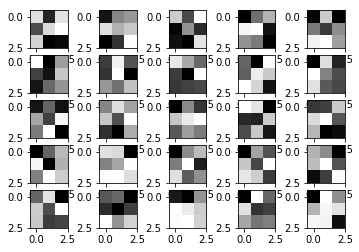

In [4]:
# Weights before training
x1w = x.get_weights()[0][:,:,0,:]
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

In [5]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
epochs = 60

model, history = fit_save_network(model, epochs, 'simplenew60')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________

## Weights after training

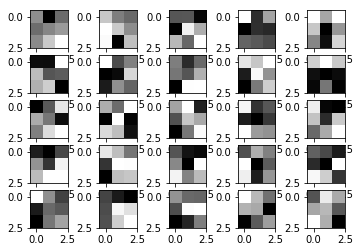

In [6]:
# Weights after training
x1w = model.get_weights()[0][:,:,0,:]
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

## Expaination

1. Given a neural network, find out the value of the weights before the network is trained and after training through visualization.


    a. How does the training affect the weights, why and how? 
We use the ReLU activation function in all convolutions. The output of the weights range from 0 to 1, as visualized in the image. ReLU, which we have used, has a lot of good aspects, such that it konverges a lot better than other activation functions. But it can suffer from dead neurons, which means that the gradient will always be zero.

    b. How would the weights be affected if they were Pereptrons.
Perceptrons output either a one or zero, which would drastically change the output of the weights after training. This is one of the reasons why we want to use a more continous approach so that not all weights are changed too drastically, which will affect earlier results poorly. It also can't handle non-linearites, which is vital for our problem.

